<span style="font-size:200%">Merk: denne notebooken er bare for dokumentasjon/planleggning. Skal live-kodes.</span>

# Plan

Mål: Hands-on illustrasjon (med det fremste av rammeverk og teknologi) av «deep learning-revolusjonen»

1. Les inn CIFAR10-data. Plot og utforsk. 
2. Sett opp enkelt, gammeldags NN i Pytorch (et layer, uten dropout, med tanh etc).
3. Bytt til Keras (for mindre skriving). Sett opp samme nett i Keras. Tren og test dette.
4. Forklar elementene i et CNN (på presentasjon)
5. Sett opp CNN i Keras, med moderne arkitektur. Tren og test dette.
6. Fancy medisinsk anvendelse (i egen pre-made notebook).

# Setup

In [82]:
# TMP
%reload_ext autoreload
%autoreload 2

Files already downloaded and verified
Files already downloaded and verified


In [83]:
%matplotlib inline

In [84]:
from utils import *

In [4]:
#%load utils.py

# Data

*Noen ord om CIFAR10: https://www.cs.toronto.edu/~kriz/cifar.html*

*Mål: Bruke NN til å klassifisere disse 32x32x3-bildene i deres 10 ulike klasser (kategorier).*

In [5]:
trainloader, testloader = get_cifar10_pytorch(batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


*Om at data lastes inn i batches. Best å prosessere data i batches (varians + gpu)*

In [6]:
trainloader.dataset.train_data.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


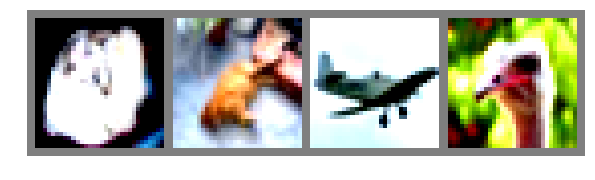

['cat', 'cat', 'plane', 'bird']


In [7]:
plot_cifar10_pytorch()

In [8]:
num_classes

10

In [9]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

# Enkelt (gammeldags) nevralt nettverk (i et hypermoderne rammeverk)

<img src="assets/pytorch.png">

*Skyte spurv med kanoner*

In [10]:
input_size = 32*32*3
hidden_size = 84

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # Gjør bildet om til en lang 32*32*3 = 3072-vektor
        x = F.tanh(self.fc1(x)) # Kjør vektoren gjennom et hidden layer og en aktiveringsfunksjon
        x = self.fc2(x) # Prediker klassen ved å kjøre gjennom output-layer
        return x

*Kommenter at fc1 har output* `x = tanh(dot(W, x) + b)`

<img src="assets/tanh.gif">

*Trenger bare definere `forward`-funksjon. `backward` blir automatisk opprettet.*

In [12]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes)

In [13]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
#list(net.parameters())
#len(list(net.parameters()))

**Trening**

Husk stegene:
1. Sett opp nevralt nettverk
2. Hent ut batch med treningsdata
3. Kjør disse gjennom nettverket for å få nettverkets prediksjoner
4. Mål avvik mellom fasit og prediskjon ved hjelp av loss-funksjon
5. Oppdater vektene ved å bruke back-propagation etterfulgt av gradient descent

*Mat inn data i nettverket:*

In [15]:
i, data = next(enumerate(trainloader, 0))

In [16]:
i

0

In [17]:
inputs, labels = data

In [18]:
len(inputs)

4

In [19]:
len(labels)

4

In [20]:
inputs[0]


(0 ,.,.) = 
 -0.0641 -0.1998 -0.1610  ...  -2.0801 -1.8863 -1.7894
 -0.1416 -0.0835 -0.1223  ...  -2.3321 -2.2740 -2.1964
 -0.1610 -0.0641  0.0134  ...  -1.7312 -2.3709 -2.3709
           ...             ⋱             ...          
 -0.1029 -0.1610  0.2461  ...   0.1879  0.1104  0.0716
 -0.2192 -0.1029  0.3430  ...   0.4593  0.2654  0.2654
 -0.2386 -0.0253  0.3430  ...   0.3817  0.3430  0.4399

(1 ,.,.) = 
  0.6498  0.4924  0.5318  ...  -2.2806 -2.0839 -2.0249
  0.5908  0.6301  0.5908  ...  -2.2609 -2.3396 -2.3199
  0.5711  0.6694  0.7481  ...  -1.3759 -2.2806 -2.3789
           ...             ⋱             ...          
  0.6498  0.5711  0.9841  ...   1.1218  1.0234  0.9054
  0.5121  0.6301  1.0824  ...   1.3774  1.1808  1.1808
  0.4138  0.6104  1.0628  ...   1.3381  1.2398  1.2791

(2 ,.,.) = 
  1.7197  1.5441  1.5831  ...  -2.1824 -2.0263 -2.0263
  1.6416  1.6612  1.6221  ...  -2.1043 -2.2019 -2.2019
  1.5441  1.6416  1.7197  ...  -1.1093 -2.1043 -2.1629
           ...            

In [21]:
labels


 5
 3
 1
 7
[torch.LongTensor of size 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


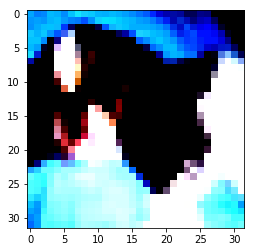

In [22]:
plt.imshow(np.transpose(torchvision.utils.make_grid(inputs[0]).numpy(), (1,2,0)))
plt.show()

In [23]:
classes[labels[0]]

'dog'

*Vi kan teste hvor godt vårt utrente nettverk med random vekter gjør det på de 10.000 testbildene. Forventer treffsikkerhet på 1/10:*

In [24]:
check_accuracy(net)

Accuracy til nettverket på de 10.000 testbildene: 10 %


*La oss mate bildene inn i nettverket. (Må wrappes i `Variable`.)*

In [25]:
inputs, labels = Variable(inputs), Variable(labels)

*Forward: Finner prediksjoner på bildene.*

In [26]:
outputs = net(inputs)

*Velg en loss-funksjon*

In [27]:
criterion = nn.CrossEntropyLoss()

*Regn ut loss:*

In [28]:
loss = criterion(outputs, labels)

In [29]:
loss

Variable containing:
 2.2422
[torch.FloatTensor of size 1]

*Backward: Finner alle vektenes bidrag til loss via backpropagation (automatisk derivasjon).*

In [30]:
loss.backward()

*Oppdaterer vektene ved å bruke SGD:*

`weight = weight - learning_rate * gradient`

In [31]:
learning_rate = 0.001

In [32]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

*Optimering: Bruker SGD til å modifisere alle vektene litt (med satt learning rate).*

In [33]:
optimizer.step()

*Nå har vi trent nettet bittelitt. Tester accuracy på nytt:*

In [34]:
check_accuracy(net)

Accuracy til nettverket på de 10.000 testbildene: 10 %


*Gjentar prosessen med neste batch av 4 bilder:*

In [35]:
i, data = next(enumerate(trainloader, 0))
inputs, labels = data
inputs, labels = Variable(inputs), Variable(labels)

In [36]:
# Må nulle ut gradientene mellom hver gang, ellers akkumuleres de:
optimizer.zero_grad()

In [37]:
outputs = net(inputs)

In [38]:
loss = criterion(outputs, labels)

In [39]:
loss

Variable containing:
 2.1661
[torch.FloatTensor of size 1]

In [40]:
loss.backward()

In [41]:
optimizer.step()

In [42]:
check_accuracy(net)

Accuracy til nettverket på de 10.000 testbildene: 11 %


*Kan gjøre dette om og om igjen:*

In [45]:
i, data = next(enumerate(trainloader, 0))
inputs, labels = data
inputs, labels = Variable(inputs), Variable(labels)
optimizer.zero_grad()
outputs = net(inputs)
loss = criterion(outputs, labels)
print(f"Loss: {loss}")
loss.backward()
optimizer.step()
check_accuracy(net)

Loss: Variable containing:
 2.3338
[torch.FloatTensor of size 1]

Accuracy til nettverket på de 10.000 testbildene: 14 %


*Tungvint... Krever mange manuelle gjennomkjøringer.. Hvor mange? Antall bilder:*

In [46]:
len(trainloader.dataset)

50000

*Antall batches på 4 hver:*

In [47]:
len(trainloader.dataset)/4

12500.0

*Må kjøre blokken over 12500 ganger for å komme én gang gjennom treningsdata.. Bedre å lage en loop:*

In [48]:
# Antall ganger gjennom hele treningsdatasettet
num_epochs = 2

In [49]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print hver 2000-ende batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            check_accuracy(net)
            running_loss = 0.0

print('Ferdig')

[1,  2000] loss: 1.951
Accuracy til nettverket på de 10.000 testbildene: 35 %
[1,  4000] loss: 1.808
Accuracy til nettverket på de 10.000 testbildene: 38 %
[1,  6000] loss: 1.789
Accuracy til nettverket på de 10.000 testbildene: 39 %
[1,  8000] loss: 1.761
Accuracy til nettverket på de 10.000 testbildene: 40 %
[1, 10000] loss: 1.732
Accuracy til nettverket på de 10.000 testbildene: 41 %
[1, 12000] loss: 1.731
Accuracy til nettverket på de 10.000 testbildene: 41 %
[2,  2000] loss: 1.665
Accuracy til nettverket på de 10.000 testbildene: 41 %
[2,  4000] loss: 1.675
Accuracy til nettverket på de 10.000 testbildene: 41 %
[2,  6000] loss: 1.663
Accuracy til nettverket på de 10.000 testbildene: 42 %
[2,  8000] loss: 1.634
Accuracy til nettverket på de 10.000 testbildene: 42 %
[2, 10000] loss: 1.667
Accuracy til nettverket på de 10.000 testbildene: 43 %
[2, 12000] loss: 1.642
Accuracy til nettverket på de 10.000 testbildene: 42 %
Ferdig


<img src="assets/tommelopp.png">

# Samme nettverk i Keras (og på GPU)

<img src="assets/kerastf.png">

In [47]:
!nvidia-smi

Tue Apr 10 17:31:16 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0  On |                  N/A |
| 27%   55C    P8    24W / 250W |   1150MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [50]:
(x_train, y_train), (x_test, y_test) = get_cifar10_keras()

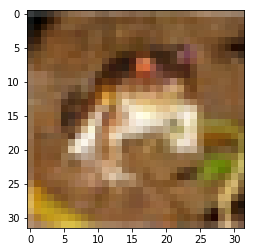

In [51]:
plt.imshow(x_train[0])
plt.show()

In [52]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Definer nettverket:

In [53]:
input_size = 32*32*3
hidden_size = 84

In [54]:
model = Sequential()

model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(hidden_size, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                258132    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                850       
Total params: 258,982
Trainable params: 258,982
Non-trainable params: 0
_________________________________________________________________


In [56]:
learning_rate = 0.001

In [57]:
opt = keras.optimizers.sgd(lr=learning_rate)

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [59]:
model.fit(x_train, y_train,
              batch_size=4,
              epochs=1,
              validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 36s 716us/step - loss: 1.8944 - acc: 0.3264 - val_loss: 1.7695 - val_acc: 0.3784


In [60]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 63us/step


[1.7694665885925294, 0.3784]

In [61]:
model.fit(x_train, y_train,
              batch_size=4,
              epochs=4,
              validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 32s 633us/step - loss: 1.7491 - acc: 0.3823 - val_loss: 1.7031 - val_acc: 0.4012
Epoch 2/5
50000/50000 [==============================] - 32s 633us/step - loss: 1.6854 - acc: 0.4090 - val_loss: 1.6616 - val_acc: 0.4176
Epoch 3/5
50000/50000 [==============================] - 32s 631us/step - loss: 1.6403 - acc: 0.4247 - val_loss: 1.6265 - val_acc: 0.4348
Epoch 4/5
50000/50000 [==============================] - 32s 634us/step - loss: 1.6051 - acc: 0.4370 - val_loss: 1.6052 - val_acc: 0.4339
Epoch 5/5
50000/50000 [==============================] - 31s 628us/step - loss: 1.5770 - acc: 0.4472 - val_loss: 1.5896 - val_acc: 0.4421


# Et moderne nettverk

In [74]:
model = Sequential()


model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [75]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6) # 65% etter 2 epoker

In [76]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [77]:
model.fit(x_train, y_train,
              batch_size=4,
              epochs=2,
              validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 72s 1ms/step - loss: 1.5000 - acc: 0.4591 - val_loss: 1.2175 - val_acc: 0.5681
Epoch 2/2
50000/50000 [==============================] - 70s 1ms/step - loss: 1.1744 - acc: 0.5857 - val_loss: 1.1028 - val_acc: 0.6174


*Forklar elementene i nettverket. Konvolusjoner, max-pooling, dropout etc*

*Vi kunne dratt inn mange triks for å booste dette. Data augmentation, ensembling, hyperparametertuning, etc. Men vi kan ikke dekke alt på 90 minutter! :-)*

In [79]:
datagen = ImageDataGenerator(
    rotation_range=5,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True  
)

model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=4), epochs=2,
                                    validation_data=(x_test, y_test))

Epoch 1/2
12500/12500 [==============================] - 69s 6ms/step - loss: 1.1977 - acc: 0.5820 - val_loss: 1.4225 - val_acc: 0.5592
Epoch 2/2
12500/12500 [==============================] - 69s 5ms/step - loss: 1.1524 - acc: 0.6018 - val_loss: 0.9583 - val_acc: 0.6766


# Et _hypermoderne_ nettverk

*DenseNet*

*Pre-trent på ImageNet*

In [101]:
(x_train, y_train), (x_test, y_test) = get_data_dn121(allData=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Lastet inn data, konverterte til størrelse egnet for DenseNet121
allData=False, så kun 3000 treningseksempler ble lastet inn


In [102]:
model = densenet121_model()

In [103]:
#model.summary()

In [104]:
model.fit(x_train, y_train, 
          batch_size=16, 
          epochs=1,
          validation_data=(x_test, y_test),
          )

Train on 3000 samples, validate on 100 samples
Epoch 1/1
3000/3000 [==============================] - 74s 25ms/step - loss: 1.0869 - acc: 0.6250 - val_loss: 0.7431 - val_acc: 0.7800


*Ser lovende ut, selv med bare 3.000 treningsbilder! Men tar lang tid... Vi laster heller inn noe jeg har trent i noen timer (på en 1080Ti). Med alle 50.000 treningsbilder, 10 epoker. Ellers nøyaktig samme som over:*

In [105]:
(x_train, y_train), (x_test, y_test) = get_data_dn121(allData=True)

Lastet inn data, konverterte til størrelse egnet for DenseNet121
Lastet inn alle 50000 treningseksempler.


In [106]:
model = densenet121_pretrained()

In [107]:
model.evaluate(x_test, y_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10000/10000 [==============================] - 61s 6ms/step


[0.14065808685636147, 0.9595]

*Knuser altså alle resultatene vi fikk over, og gjør Cifar10 omtrent ubrukelig som benchmark!*

# Mer interessant anvendelse

Gå til `2.0-medisinske-bilder.ipynb`

Men først: shut down

<img src="assets/shutdown.png">